## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/EEG-Seizure-Detection')

In [ ]:
from IPython.display import clear_output
!pip install -r /content/drive/MyDrive/EEG-Seizure-Detection/requirement.txt
clear_output()

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from glob import glob
from tqdm.notebook import tqdm

In [ ]:
# from utils.features.statistical_features import StatisticalFeatures
from utils.preprocessing.convert_montage import convert_to_bipolar
from utils.plots import plot_eeg_lbl, plot_eeg_tse

from utils import read_lbl_file

### Kaggle API Download

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json # Change the file permissions to read/write to the owner only

In [ ]:
!kaggle datasets download -d psyryuvok/the-tuh-eeg-seizure-corpus-tusz-v152

100% 34.8G/34.8G [06:00<00:00, 163MB/s]
100% 34.8G/34.8G [06:00<00:00, 104MB/s]


In [ ]:
# !rm -rf  /content/the-tuh-eeg-seizure-corpus-tusz-v152
!mkdir /content/the-tuh-eeg-seizure-corpus-tusz-v152
!cat /content/drive/MyDrive/EEG-Seizure-Detection/data/unzip_train_files.txt | xargs -I {} unzip /content/the-tuh-eeg-seizure-corpus-tusz-v152.zip '{}/*' -d /content/the-tuh-eeg-seizure-corpus-tusz-v152
# !rm /content/the-tuh-eeg-seizure-corpus-tusz-v152.zip
clear_output()

In [ ]:
# Remove files with only the background class that were unzipped.
tse_paths = glob('/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/**/**/**/**/*.tse')
for path in tqdm(tse_paths, 'Processing'):
    tse_label_df = pd.read_csv(path, sep=' ', header=0, names=['start time(s)', 'stop time(s)', 'multi class code', 'probability'])
    if (tse_label_df['multi class code'].unique()).all()== 'bckg':
        os.remove(path)
        if os.path.exists(path.replace('.tse', '.lbl')):
            os.remove(path.replace('.tse', '.lbl'))
        if os.path.exists(path.replace('.tse', '.lbl_bi')):
            os.remove(path.replace('.tse', '.lbl_bi'))
        if os.path.exists(path.replace('.tse', '.edf')):
            os.remove(path.replace('.tse', '.edf'))
        if os.path.exists(path.replace('.tse', '.tse_bi')):
            os.remove(path.replace('.tse', '.tse_bi'))
        if os.path.exists(path.replace('.tse', '.txt')):
            os.remove(path.replace('.tse', '.txt'))

Processing:   0%|          | 0/1548 [00:00<?, ?it/s]

## Exploration

In [ ]:
lbl_path = '/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/02_tcp_le/005/00000529/s002_2003_05_07/00000529_s002_t001.lbl_bi'

lbl_dict = read_lbl_file(lbl_path)
lbl_dict

In [ ]:
file_path = '/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/00006175_s002_t000.edf'

plot_eeg_lbl(eeg_path=file_path, to_bipolar=True, plot_height=2, plot_width=190, save_dst='/content/drive/MyDrive/EEG-Seizure-Detection/assets/plot_images/lbl_plots')
plot_eeg_tse(eeg_path=file_path, to_bipolar=True, plot_height=2, plot_width=190, save_dst='/content/drive/MyDrive/EEG-Seizure-Detection/assets/plot_images/tse_plots')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from utils.preprocessing import Preprocessor

file_path = '/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/004/00000492/s003_2003_07_18/00000492_s003_t000.edf'
signal = mne.io.read_raw_edf(file_path, verbose=False).get_data()[0]


# Define STFT parameters
window_length = 256  # Length of analysis window
overlap = 128         # Overlap between windows

# Calculate the spectrogram
_sampling_rate = 400


# signal = Preprocessor.bandpass(eeg_signal=signal, low_cutoff_freq=20, high_cutoff_freq=60, sampling_rate=_sampling_rate)
signal = Preprocessor.notch(eeg_signal=signal, notch_freq=60, quality_factor=0.8, sampling_rate=_sampling_rate)
# signal = Preprocessor.high_pass(eeg_signal=signal, cutoff_freq=60, sampling_rate=_sampling_rate)


frequencies, times, Sxx = spectrogram(signal, fs=_sampling_rate, window='hamming', nperseg=window_length, noverlap=overlap)

# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Applying logarithmic scaling for visualization
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()

TypeError: ignored

In [ ]:
eeg_data

<RawEDF | 00000492_s003_t000.edf, 32 x 66000 (165.0 s), ~36 kB, data not loaded>

In [ ]:
!cat /content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/004/00000492/s003_2003_07_18/00000492_s003_t000.tse

version = tse_v1.0.0

0.0000 6.2825 bckg 1.0000
6.2825 35.8875 gnsz 1.0000
35.8875 165.0000 bckg 1.0000


In [ ]:
!cat /content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/004/00000492/s003_2003_07_18/00000492_s003_t000.lbl

In [ ]:
file_path = '/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/00006175_s002_t000.edf'
eeg_data = mne.io.read_raw_edf(file_path)

eeg_data

Extracting EDF parameters from /content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/00006175_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | 00006175_s002_t000.edf, 36 x 302000 (1208.0 s), ~40 kB, data not loaded>

In [ ]:
eeg_data.get_data().shape

(36, 302000)

In [ ]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10)
ica_components = ica.fit_transform(eeg_data.get_data())
ica_components.shape

In [ ]:
import numpy as np
frequencies = np.fft.fftfreq(N, d=dt)  # N is the DFT length, dt is the sample spacing


In [ ]:
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Load your audio signal here
# For this example, let's assume 'signal' contains your audio data
# sampling_rate is the sampling rate of your signal

# Define STFT parameters
window_length = 256  # Length of analysis window
overlap = 128         # Overlap between windows

# Calculate the spectrogram
sampling_rate = 250

for signal in eeg_data.get_data():
    frequencies, times, Sxx = spectrogram(signal, fs=sampling_rate, window='hamming', nperseg=window_length, noverlap=overlap)

    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Applying logarithmic scaling for visualization
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from utils.features.frequency_domain import FourierFeaturesExtractor

In [ ]:
spectrogram?

In [ ]:
pip install pyemd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

# Generate or load your time-series data
# For this example, let's assume you have a 1D signal 'signal'

# Initialize the EMD object
emd = EMD()

# Perform EMD decomposition
IMFs = emd(signal)

# Plot the IMFs
plt.figure(figsize=(12, 6))
for i, imf in enumerate(IMFs):
    plt.subplot(len(IMFs), 1, i+1)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()
    plt.grid()
    plt.title(f'IMF {i+1}')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

In [ ]:
EMD?

In [ ]:
import numpy as np
T = np.linspace(0, 1, 100)
S = np.sin(2*2*np.pi*T)
emd = EMD(extrema_detection='parabol')
IMFs = emd.emd(S)
IMFs.shape

(2, 100)

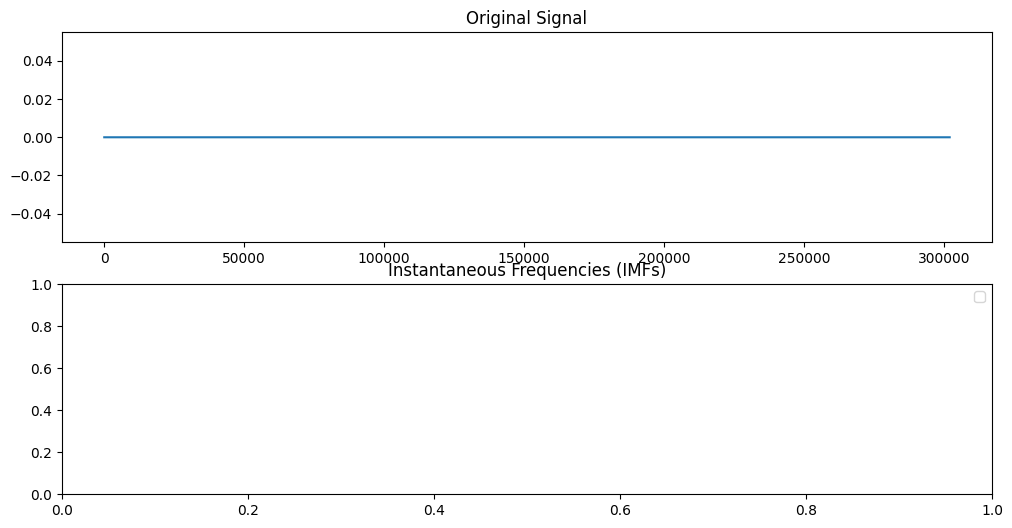

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD


# Generate or load your time-series data
# For this example, let's assume you have a 1D signal 'signal'

# Initialize the EMD object
emd = EMD()

# Perform EMD decomposition
IMFs = emd(signal)

# Calculate the Hilbert Transform for each IMF
hilbert_IMFs = [np.abs(signal) * np.exp(1j * np.angle(signal)) for signal in IMFs]

# Calculate instantaneous frequency for each IMF
inst_freq = [np.diff(np.unwrap(np.angle(hilbert_signal))) / (2 * np.pi) for hilbert_signal in hilbert_IMFs]

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(signal, label='Original Signal')
plt.title('Original Signal')
plt.subplot(212)
for i, freq in enumerate(inst_freq):
    plt.plot(freq, label=f'IMF {i+1}')
plt.title('Instantaneous Frequencies (IMFs)')
plt.legend()
plt.show()

In [ ]:
pip install PyWavelets


In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt


In [ ]:
# Generate a sample signal (you should replace this with your own data)
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)

wavelet = 'db1'  # Example: Daubechies wavelet db1
scales = np.arange(1, 128)  # Adjust the range of scales as needed
coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coefficients), extent=[0, len(signal), min(scales), max(scales)], aspect='auto', cmap='coolwarm')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform')
plt.xlabel('Time')
plt.ylabel('Scale/Frequency')
plt.show()


AttributeError: ignored

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Generate a sample signal (replace this with your data)
t = np.linspace(0, 1, 1000)
signal = eeg_data.get_data()[0]
# signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)

# Choose a wavelet function
# wavelet = 'morl'  # Example: Morlet wavelet
wavelet = 'db1'  # Example: Daubechies wavelet db1


# Define scales for the CWT
scales = np.arange(1, 128)  # Adjust the range of scales as needed

# Perform Continuous Wavelet Transform (CWT)
cwt_coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

# Plot the real part of the CWT coefficients
plt.figure(figsize=(12, 6))
plt.imshow(np.real(cwt_coefficients), extent=[0, len(signal), min(scales), max(scales)], aspect='auto', cmap='coolwarm')
plt.colorbar(label='Real Part')
plt.title('Complex Continuous Wavelet Transform (Real Part)')
plt.xlabel('Time')
plt.ylabel('Scale/Frequency')
plt.show()


AttributeError: ignored

In [ ]:
help(pywt.cwt)

Help on function cwt in module pywt._cwt:

cwt(data, scales, wavelet, sampling_period=1.0, method='conv', axis=-1)
    cwt(data, scales, wavelet)
    
    One dimensional Continuous Wavelet Transform.
    
    Parameters
    ----------
    data : array_like
        Input signal
    scales : array_like
        The wavelet scales to use. One can use
        ``f = scale2frequency(wavelet, scale)/sampling_period`` to determine
        what physical frequency, ``f``. Here, ``f`` is in hertz when the
        ``sampling_period`` is given in seconds.
    wavelet : Wavelet object or name
        Wavelet to use
    sampling_period : float
        Sampling period for the frequencies output (optional).
        The values computed for ``coefs`` are independent of the choice of
        ``sampling_period`` (i.e. ``scales`` is not scaled by the sampling
        period).
    method : {'conv', 'fft'}, optional
        The method used to compute the CWT. Can be any of:
            - ``conv`` uses ``numpy

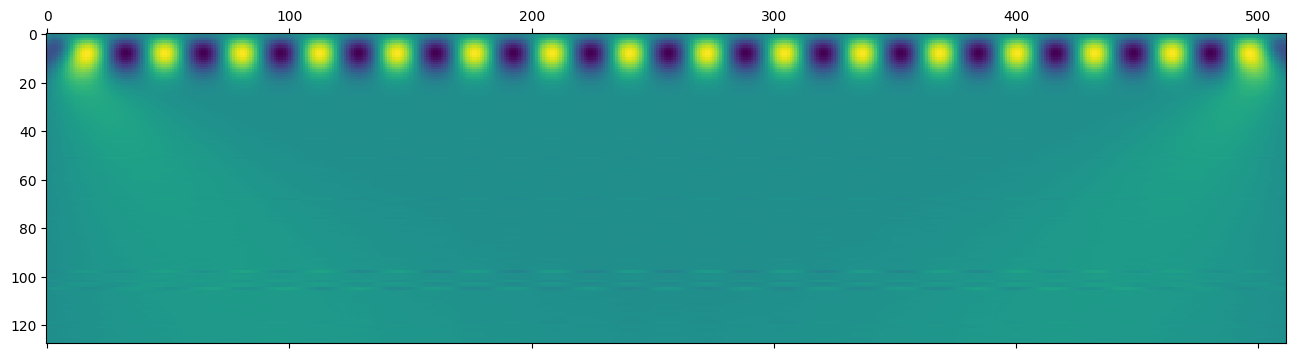

(128, 512)


In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP
print(coef.shape)

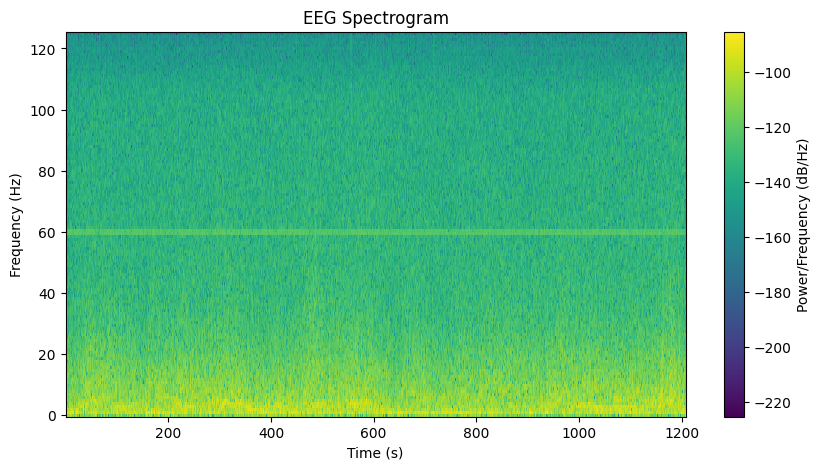

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

class EEGSpectrogram:
    def __init__(self, signal, sampling_rate, window_length=256, overlap=128):
        """
        Initialize the EEGSpectrogram object.

        Parameters:
            signal (array-like): The EEG signal.
            sampling_rate (int): The sampling rate of the EEG signal (samples per second).
            window_length (int, optional): Length of the analysis window for the STFT (default: 256).
            overlap (int, optional): Overlap between successive windows (default: 128).
        """
        self.signal = signal
        self.sampling_rate = sampling_rate
        self.window_length = window_length
        self.overlap = overlap

    def compute_spectrogram(self):
        """
        Compute the spectrogram of the EEG signal.

        Returns:
            frequencies (array): The frequencies.
            times (array): The time points.
            spectrogram_data (array): The spectrogram data.
        """
        frequencies, times, Sxx = spectrogram(self.signal, fs=self.sampling_rate, window='hamming', nperseg=self.window_length, noverlap=self.overlap)
        return frequencies, times, 10 * np.log10(Sxx)  # Applying logarithmic scaling for visualization

    def plot_spectrogram(self):
        """
        Plot the spectrogram of the EEG signal.
        """
        frequencies, times, spectrogram_data = self.compute_spectrogram()

        plt.figure(figsize=(10, 5))
        plt.pcolormesh(times, frequencies, spectrogram_data)
        plt.colorbar(label='Power/Frequency (dB/Hz)')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('EEG Spectrogram')
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Load or generate your EEG signal and specify the sampling rate
    eeg_signal = eeg_data.get_data()[0]  # Replace with your EEG data
    sampling_rate = 250  # Replace with your actual sampling rate

    # Create an EEGSpectrogram object
    eeg_spec = EEGSpectrogram(eeg_signal, sampling_rate)

    # Plot the spectrogram
    eeg_spec.plot_spectrogram()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert

class HilbertTransform:
    def __init__(self, signal, sampling_rate):
        """
        Initialize the HilbertHuangTransform object.

        Parameters:
            signal (array-like): The signal on which to perform the HHT.
            sampling_rate (int): The sampling rate of the signal (samples per second).
        """
        self.signal = signal
        self.sampling_rate = sampling_rate

    def compute_hht(self):
        """
        Compute the Hilbert-Huang Transform (HHT) of the signal.

        Returns:
            imfs (list of arrays): The Intrinsic Mode Functions (IMFs) obtained from Empirical Mode Decomposition (EMD).
            inst_freqs (list of arrays): The instantaneous frequencies corresponding to each IMF.
        """
        emd = EMD()
        imfs = emd(self.signal)
        inst_freqs = [np.diff(np.unwrap(np.angle(hilbert(imf)))) / (2 * np.pi) for imf in imfs]
        return imfs, inst_freqs


(9, 1000)


ValueError: ignored

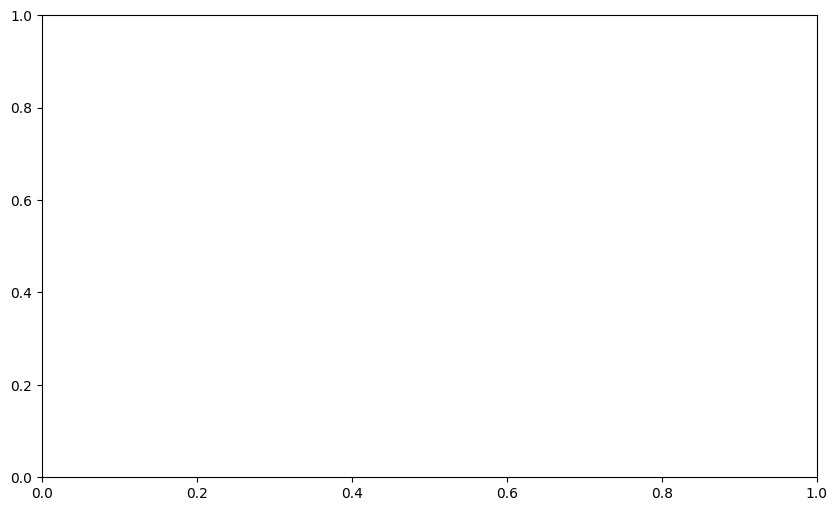

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert

# Create or load your signal
# Replace this with your actual signal
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)

# Perform Empirical Mode Decomposition (EMD) to obtain IMFs
emd = EMD()
imfs = emd(signal)

# Initialize arrays to store instantaneous frequency and amplitude
instantaneous_frequency = []
amplitude = []

# Calculate instantaneous frequency and amplitude for each IMF
for imf in imfs:
    analytic_signal = hilbert(imf)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency.append(np.gradient(instantaneous_phase) / (2 * np.pi))
    amplitude.append(np.abs(analytic_signal))

# Calculate the Hilbert Spectral Density (HSD)
# This can be done by summing the squared amplitude over all IMFs
hsd = np.sum(np.array(amplitude) ** 2, axis=0)

# Plot the Hilbert Spectrum
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, np.arange(1, len(t) + 1), hsd, shading='auto', cmap='jet')
plt.colorbar(label='Hilbert Spectral Density')
plt.title('Hilbert Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert

# Create or load your signal
# Replace this with your actual signal
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)

# Perform Empirical Mode Decomposition (EMD) to obtain IMFs
emd = EMD()
imfs = emd(signal)

# Initialize arrays to store instantaneous frequency and amplitude
instantaneous_frequency = []
amplitude = []

# Calculate instantaneous frequency and amplitude for each IMF
for imf in imfs:
    analytic_signal = hilbert(imf)
    instantaneous_frequency.append(np.angle(analytic_signal) / (2 * np.pi))
    amplitude.append(np.abs(analytic_signal))

# Calculate the Hilbert Spectral Density (HSD)
# This can be done by summing the squared amplitude over all IMFs
hsd = np.sum(np.array(amplitude) ** 2, axis=0)

# Create time and frequency grids
time_grid, frequency_grid = np.meshgrid(t, np.arange(1, len(t) + 1))

time_grid.shape

plt.imshow(frequency_grid)
# Plot the Hilbert Spectrum
plt.figure(figsize=(10, 6))
plt.pcolormesh(time_grid, frequency_grid, hsd, shading='auto', cmap='jet')
plt.colorbar(label='Hilbert Spectral Density')
plt.title('Hilbert Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert

# Create or load your signal
# Replace this with your actual signal
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)


# Perform Empirical Mode Decomposition (EMD) to obtain IMFs
emd = EMD()
imfs = emd(signal)


# Initialize arrays to store instantaneous frequency and amplitude
instantaneous_frequency = []
amplitude = []

# Calculate instantaneous frequency and amplitude for each IMF
for imf in imfs:
    analytic_signal = hilbert(imf)
    instantaneous_frequency.append(np.angle(analytic_signal) / (2 * np.pi))
    amplitude.append(np.abs(analytic_signal))

# # Calculate the Hilbert Spectral Density (HSD)
# # This can be done by summing the squared amplitude over all IMFs
# hsd = np.sum(np.array(amplitude) ** 2, axis=0)

# # Create time and frequency grids
# time_grid, frequency_grid = np.meshgrid(t, np.arange(1, len(t) + 1))

# # Transpose the hsd array for compatibility with time_grid and frequency_grid
# hsd = hsd.T

# # Plot the Hilbert Spectrum
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(time_grid, frequency_grid, hsd, shading='auto', cmap='jet')
# plt.colorbar(label='Hilbert Spectral Density')
# plt.title('Hilbert Spectrum')
# plt.xlabel('Time')
# plt.ylabel('Frequency (Hz)')
# plt.show()


(1000,)
(1000,)
(1000,)
(1000,)


<ipython-input-37-66a876e303ec>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  hilbert_spectrum[i, :] = hilbert(imf)


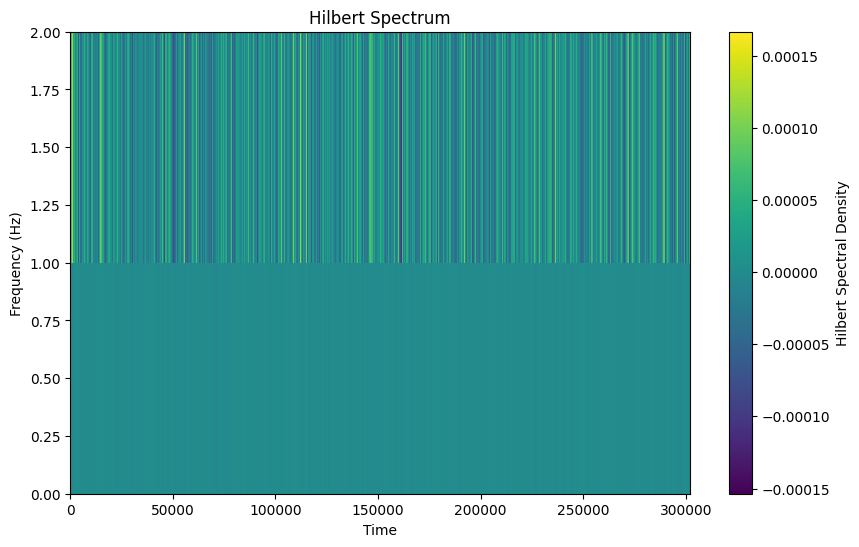

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert


signal = eeg_data.get_data()[0]

# Perform Empirical Mode Decomposition (EMD) to obtain IMFs
emd = EMD()
imfs = emd(signal)

# Initialize arrays to store instantaneous frequency and amplitude
instantaneous_frequency = []
amplitude = []
hilbert_spectrum = np.zeros(shape=imfs.shape)
# Calculate instantaneous frequency and amplitude for each IMF
for i, imf in enumerate(imfs):
    hilbert_spectrum[i, :] = hilbert(imf)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency.append(np.gradient(instantaneous_phase) / (2 * np.pi))
    amplitude.append(np.abs(analytic_signal))

# Calculate the Hilbert Spectral Density (HSD)
# This can be done by summing the squared amplitude over all IMFs
hsd = np.sum(np.array(amplitude) ** 2, axis=0)

# Plot the Hilbert Spectrum
plt.figure(figsize=(10, 6))
plt.pcolormesh(hilbert_spectrum)
# plt.pcolormesh(t, np.arange(1, len(t) + 1), hsd, shading='auto', cmap='jet')
plt.colorbar(label='Hilbert Spectral Density')
plt.title('Hilbert Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()


<ipython-input-20-e78c4f9f8ccd>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  hs[i,:] = hilbert(imfs[i])


AttributeError: ignored

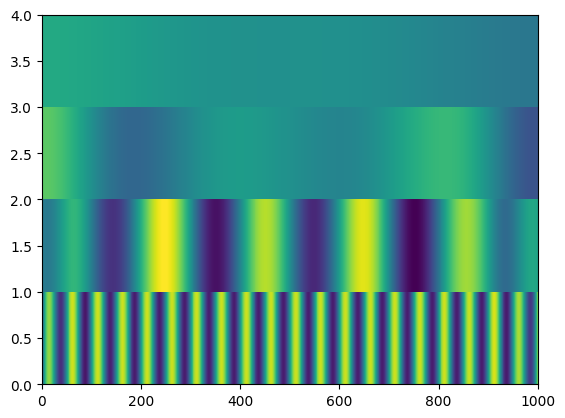

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from PyEMD import EMD

emd = EMD()
imfs = emd(signal)


hs = np.zeros((len(imfs), len(imfs[0])))
for i in range(len(imfs)):
    hs[i,:] = hilbert(imfs[i])

plt.figure()
plt.pcolormesh(hs)
plt.shading('flat')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Hilbert Spectrum')
plt.colorbar()
plt.show()


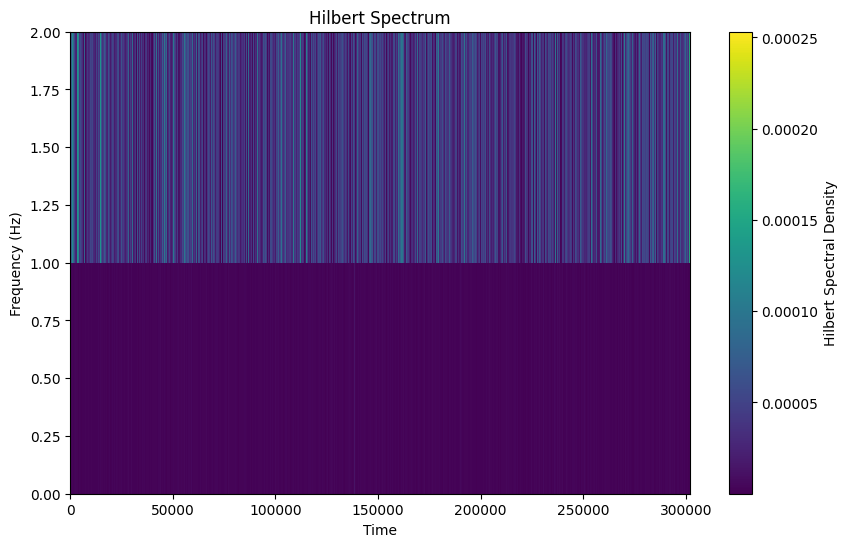

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert

class HilbertSpectrumCalculator:
    def __init__(self, eeg_data):
        self.signal = eeg_data
        self.emd = EMD()
        self.imfs = self.emd(self.signal)

    def compute_hilbert_spectrum(self):
        # Initialize arrays to store instantaneous frequency and amplitude
        instantaneous_frequency = []
        amplitude = []
        hilbert_spectrum = np.zeros(shape=self.imfs.shape)

        # Calculate instantaneous frequency and amplitude for each IMF
        for i, imf in enumerate(self.imfs):
            analytic_signal = hilbert(imf)
            instantaneous_phase = np.unwrap(np.angle(analytic_signal))
            instantaneous_frequency.append(np.gradient(instantaneous_phase) / (2 * np.pi))
            amplitude.append(np.abs(analytic_signal))
            hilbert_spectrum[i, :] = np.abs(analytic_signal)

        # Calculate the Hilbert Spectral Density (HSD)
        # This can be done by summing the squared amplitude over all IMFs
        hsd = np.sum(np.array(amplitude) ** 2, axis=0)

        return hilbert_spectrum, hsd

    def plot_hilbert_spectrum(self):
        hilbert_spectrum, hsd = self.compute_hilbert_spectrum()

        # Plot the Hilbert Spectrum
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(hilbert_spectrum)
        plt.colorbar(label='Hilbert Spectral Density')
        plt.title('Hilbert Spectrum')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.show()

# Usage:
# Instantiate the class with your EEG data
# eeg_data = ...  # Provide your EEG data here
spectrum_calculator = HilbertSpectrumCalculator(eeg_data)
spectrum_calculator.plot_hilbert_spectrum()


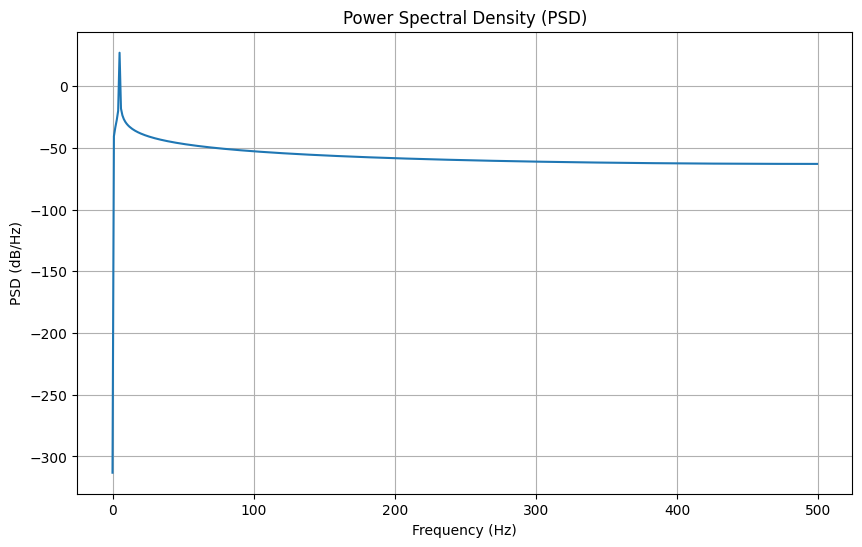

In [1]:
import numpy as np

def compute_psd(signal, sample_rate):
    # Calculate the FFT of the signal
    fft_result = np.fft.fft(signal)
    
    # Compute the frequency axis
    n = len(signal)
    frequencies = np.fft.fftfreq(n, 1 / sample_rate)
    
    # Calculate the one-sided power spectral density
    psd = np.abs(fft_result) ** 2 / n
    
    # Take the positive frequencies and multiply by 2 (except for DC component)
    psd = 2 * psd[:n // 2]
    
    # Compute the corresponding frequencies for the one-sided PSD
    positive_frequencies = frequencies[:n // 2]
    
    return positive_frequencies, psd

import matplotlib.pyplot as plt

# Create a time vector
t = np.linspace(0, 1, 1000)  # 1 second of data sampled at 1000 Hz

# Create a sinusoidal signal
frequency = 5  # Frequency of the sinusoid in Hz
amplitude = 1.0
signal = amplitude * np.sin(2 * np.pi * frequency * t)

# Sample rate
sample_rate = 1000  # 1000 Hz

# Compute the PSD
frequencies, psd = compute_psd(signal, sample_rate)

# Create a plot for the PSD
plt.figure(figsize=(10, 6))
plt.plot(frequencies, 10 * np.log10(psd))  # Convert to dB
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.grid()
plt.show()

